# Exploration of Craiglist Used Cars Sale Prices 

## Used car price prediction with Machine Learning

##### 1. Project background and aim

#### Craiglist is an internet marketplace for a variety of new and used items. It allows you to, for example, purchase and sell things that you no longer need or purchase an item that fit in your budget. One challenge that the craiglist car data set from Kaggle gives is determining the optimal car price based on the various features provided. 
#### The aim of this project is to propose a data-driven solution, by using machine learning to predict the car sale price.

#### 2. Data Description

#### For this project, the data set derives from Kaggle. Each row in the data set is a listing available for a used car on craiglist for various cities and states within the United States. The columns describe different characteristics for each car listing(features). 
#### Features for this project are the following:
##### Year: the year of the car
##### Manufacturer: the make of the vehicle (Toyota, Nissan,etc.)
##### Model: the name of a car project (Camry, SUV,etc.)
##### Condition: the current state of the car ranging from excellent, very good, good, fair, poor. 
##### Cylinders: known to be the power unit of an engine where the gasoline is burned and turned into power. Cylinders range from 4, 6, and 8. 
##### Fuel: a type of energy source that provides power to vehicles 
##### Title Status: a document that consists of the legal owner of the vehicle (Yes/No)
##### Transmission: the part of the car the turns the engine's power into something the car can use
##### Drive: is the wheel of a motor vehicle that transmit force which causes the vehicle to move
##### Size: size of the listed car (compact,mid-size,full-size,etc.)
##### Type: the type of car (wagon, pickup,SUV,etc.)
##### Paint Color: color of the listed car
##### State: location in which the car is being sold
##### Odometer: the logarithmic measure of the distance traveled by the listed vehicle

#### Install required packages

In [104]:
# Loading libraries required and reading dataset into python
import pandas as pd
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')


# Modeling
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error as mae,r2_score
from sklearn import linear_model
import sklearn.model_selection as ms
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

#### Cleaning and pre-processing

In [2]:
df = pd.read_csv('cleaned_cars.csv')
df = df.drop(columns = ['Unnamed: 0'],axis = 1)
print(f'The dataset contains {len(df)} car listings')

The dataset contains 19279 car listings


#### Using 15% of the dataset for modeling

In [3]:
data = df.sample(frac = 0.15)
print(f'The sample dataset contains {len(data)} car listings')

The sample dataset contains 2892 car listings


In [4]:
data.isna().sum()
print('The dataset contains no missing values.')

The dataset contains no missing values.


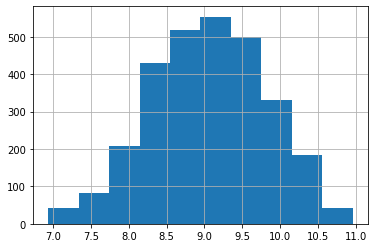

In [5]:
# Distribution of the target variable: price
data.price_log.hist()

In [6]:
data.describe()

year    price_log  odometer_log
count  2892.000000  2892.000000   2892.000000
mean   2008.719571     9.060577     11.526422
std       6.965537     0.761261      0.705517
min    1961.000000     6.935370      7.021976
25%    2006.000000     8.516993     11.264592
50%    2010.000000     9.093132     11.673351
75%    2013.000000     9.615805     11.958167
max    2020.000000    10.962146     16.118097

In [7]:
# Turn Categorical Features into dummy variables
data  = pd.get_dummies(data, drop_first=True)
data.columns

Index(['year', 'price_log', 'odometer_log', 'manufacturer_alfa-romeo', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt', 'state_wa', 'state_wi', 'state_wv', 'state_wy'], dtype='object', length=1452)

In [8]:
def printErrors(Yt,predMod):
    """
    This function takes the following inputs:
    1. Yt = the trained predicted values
    2. predMod = the prediction from the fitted model
    It thens prints the errors for the model ie MAE, MSE, RMSLE
    """
    errors = abs(np.expm1(predMod) - np.expm1(Yt))
    print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
    print('Mean Squared Error (MSE):', mean_squared_error(Yt, predMod))
    print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Yt, predMod)))
    print('Root Mean Square Log Error (RMSLE):', np.sqrt(mean_squared_log_error(Yt, predMod)))
    mape = 100 * (errors / np.expm1(Yt))
    print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

In [9]:
def printMod(Xtr,Xte,Ytr, Yte, modSel, modName):
    """
    This function takes the following inputs:
    1. Xtr,Xte,Ytr,Yte = X train data set, X test data set, Y train array, Y test array
    2. modSel is the fitted model
    3. modName is the model name used for plotting i.e. Lasso, Random Forest
    It then creates a plot for test vs train predicted prices
    """
    y_train_eNet = modSel.predict(Xtr)
    y_test_eNet = modSel.predict(Xte)
    # Plot predictions
    plt.figure(figsize=(12,8))
    plt.scatter(np.expm1(y_train_eNet), np.expm1(Ytr), c='black', marker="o", s=15, label = "Training data")
    plt.scatter(np.expm1(y_test_eNet), np.expm1(Yte), c='orange', marker='o', s=15, label = "Test data")
    plt.title(modName + " Model Train vs Test", fontsize = 20)
    plt.xlabel("Predicted Prices", fontsize = 16)
    plt.ylabel("Actual Prices", fontsize = 16)
    plt.xlim(0, 80000)
    plt.ylim(0, 80000)
    plt.legend(loc = "upper left")
    plt.plot([0,80000], [0,80000 ], c = "grey")
    plt.show()

In [10]:
def rmse_stack(model):
    """
    Perform kfold cross validation on stack model
    k = 5
    """
    kf = KFold(n_splits = 5, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, np.array(X_train), Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [11]:
kfo = KFold(n_splits=5,shuffle = True, random_state = 28)

In [12]:
# Setting feature variables in x , target in y
x = data.loc[:,data.columns != 'price_log'].copy()
y = data['price_log'].reset_index(drop=True)
print('train', x.shape, 'y', y.shape)

train (2892, 1451) y (2892,)


#### Model Preparation

In [13]:
# Performing train test split to train the models
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.35,random_state = 123, shuffle = True)

In [14]:
# Regex correction incase a column name has any symbols like: ([],<,etc.)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [15]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [16]:
print('train', X_test.shape, 'y', X_train.shape)

train (1013, 1451) y (1879, 1451)


In [17]:
# Scale Data to center around zero.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns= X_test.columns)
X_train_scaled.head()

year  odometer_log  manufacturer_alfa-romeo  manufacturer_audi  manufacturer_bmw  manufacturer_buick  manufacturer_cadillac  manufacturer_chevrolet  manufacturer_chrysler  manufacturer_dodge  manufacturer_fiat  manufacturer_ford  manufacturer_gmc  manufacturer_honda  manufacturer_hyundai  manufacturer_infiniti  manufacturer_jaguar  manufacturer_jeep  manufacturer_kia  manufacturer_lexus  manufacturer_lincoln  manufacturer_mazda  manufacturer_mercedes-benz  manufacturer_mercury  manufacturer_mini  manufacturer_mitsubishi  manufacturer_nissan  manufacturer_pontiac  manufacturer_porche  manufacturer_ram  manufacturer_rover  manufacturer_saturn  manufacturer_subaru  manufacturer_tesla  manufacturer_toyota  manufacturer_volkswagen  manufacturer_volvo  model_1 series  model_128i  model_128i convertible  model_150 reg cab  model_1500  model_1500 4x4  model_1500 4x4 crew cab  model_1500 5.2 4x4  model_1500 big horn  model_1500 crew cab  model_1500 crew cab 4x4  \
0 -0.077126      0.774840                -0.023076          -0.098347         -0.153038           -0.127377              -0.125203               -0.415823               -0.14367           -0.161911          -0.032642          -0.520051         -0.258858            -0.22948              7.850690              -0.076738            -0.046188          -0.224293         -0.125203           -0.103723             -0.083467           -0.103723                   -0.149355             -0.073147          -0.076738                 -0.06539            -0.238339             -0.116122            -0.023076         -0.210877           -0.056599            -0.083467            -0.149355           -0.032642            -0.293474                -0.154849           -0.092673       -0.032642   -0.032642                     0.0                0.0   -0.116122       -0.032642                -0.023076           -0.023076            -0.023076            -0.023076                      0.0   
1  0.344151      0.806412                -0.023076          -0.098347         -0.153038           -0.127377              -0.125203                2.404869               -0.14367           -0.161911          -0.032642          -0.520051         -0.258858            -0.22948             -0.127377              -0.076738            -0.046188          -0.224293         -0.125203           -0.103723             -0.083467           -0.103723                   -0.149355             -0.073147          -0.076738                 -0.06539            -0.238339             -0.116122            -0.023076         -0.210877           -0.056599            -0.083467            -0.149355           -0.032642            -0.293474                -0.154849           -0.092673       -0.032642   -0.032642                     0.0                0.0   -0.116122       -0.032642                -0.023076           -0.023076            -0.023076            -0.023076                      0.0   
2 -0.779253      0.540876                -0.023076          -0.098347         -0.153038           -0.127377              -0.125203               -0.415823               -0.14367           -0.161911          -0.032642          -0.520051         -0.258858            -0.22948             -0.127377              -0.076738            -0.046188          -0.224293         -0.125203           -0.103723             -0.083467           -0.103723                   -0.149355             -0.073147          -0.076738                 -0.06539             4.195707             -0.116122            -0.023076         -0.210877           -0.056599            -0.083467            -0.149355           -0.032642            -0.293474                -0.154849           -0.092673       -0.032642   -0.032642                     0.0                0.0   -0.116122       -0.032642                -0.023076           -0.023076            -0.023076            -0.023076                      0.0   
3 -0.638828      0.562591                -0.023076          -0.098347         -0.153038           -

#### Lasso Model

In [18]:
lasMod = linear_model.Lasso(normalize= True)
lasMod = lasMod.set_params(random_state = 42)
lasMod.fit(X_train_scaled,y_train) 

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=42, selection='cyclic',
      tol=0.0001, warm_start=False)

In [19]:
lasso_pred = lasMod.predict(X_test_scaled)
printErrors(y_test,lasso_pred)

Mean Absolute Error (MAE): $ 6311.26
Mean Squared Error (MSE): 0.5778230652381522
Root Mean Square Error (RMSE): 0.7601467392800894
Root Mean Square Log Error (RMSLE): 0.07625078265160884
Mean Absolute Percent Error (MAPE): 74.08 %.


In [20]:
lasMod.score(X_test_scaled,y_test)

-0.00041793341035489817

#### Lasso Model Grid Search

In [21]:
alphas = [0.00024869479793950395]
param_grid_lasso = {"max_iter": [20],
                     "alpha": alphas}

In [22]:
grid_search_lasso = ms.GridSearchCV(lasMod, param_grid_lasso, scoring= 'neg_mean_squared_error', 
                                    cv= kfo, n_jobs=-1, return_train_score = True)

%time grid_search_lasso.fit(X_train_scaled, y_train)

Wall time: 1.99 s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.00024869479793950396], 'max_iter': [20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [23]:
# Prediction using the tuned parameters
grid_lasso = grid_search_lasso.best_estimator_

In [24]:
#Prediction with tuned hyperparameters
grid_lasso_pred = grid_lasso.predict(X_test_scaled)
printErrors(y_test,grid_lasso_pred)

Mean Absolute Error (MAE): $ 3155.94
Mean Squared Error (MSE): 0.20275119681428208
Root Mean Square Error (RMSE): 0.45027902106836165
Root Mean Square Log Error (RMSLE): 0.046654131501761315
Mean Absolute Percent Error (MAPE): 34.76 %.


In [25]:
print("The train set R^2 is: %.5f" % grid_lasso.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_lasso.score(X_test_scaled, y_test))

The train set R^2 is: 0.82561
The test set R^2 is is: 0.64897


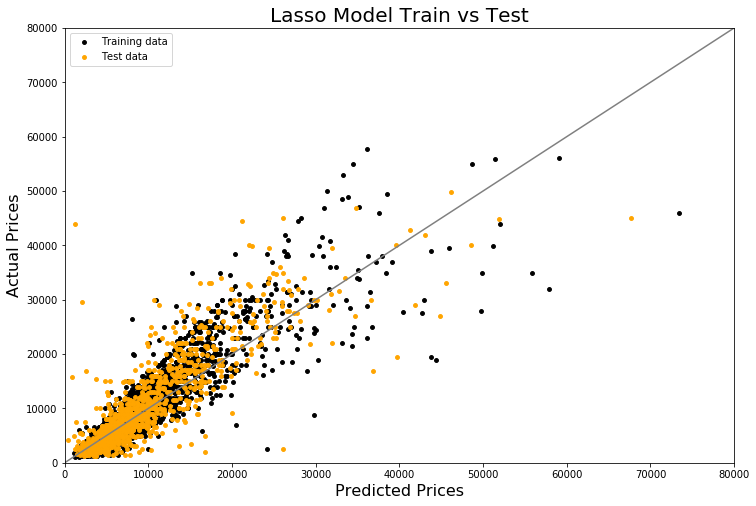

In [26]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_lasso,"Lasso")

In [132]:
coeff = pd.DataFrame({"feature":X_train_scaled.columns,"coeff":grid_lasso.coef_})
coeff = coeff.sort_values(by = 'coeff', ascending = False)

print(coeff[coeff.coeff!=0].shape)
mod_=coeff[coeff.coeff!=0]
mod_.head(5)

(293, 2)


feature     coeff
0                          year  0.365880
1361      cylinders_8 cylinders  0.076553
1387                 type_truck  0.076207
558                  model_f100  0.069188
866   model_mustang convertible  0.063218

In [133]:
coefs_lasso  = []

for alpha in alphas:
        grid_lasso.set_params(alpha=alpha)
        grid_lasso.fit(X_train_scaled, y_train)  
        coefs_lasso.append(grid_lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_scaled.columns)  

###### Results

In [29]:
info = [['Lasso',mean_squared_error(y_test,lasso_pred),(lasMod.score(X_test_scaled,y_test))],
        ['Lasso Grid Search',mean_squared_error(y_test,grid_lasso_pred),grid_lasso.score(X_test_scaled, y_test)]]
lasso_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
lasso_info

Name       MSE  R2-Score
0              Lasso  0.577823 -0.000418
1  Lasso Grid Search  0.202751  0.648965

##### Elastic Net Model

In [30]:
# Elastic Net
eNet = linear_model.ElasticNet(normalize=True)
eNet = eNet.set_params(random_state = 42)

#fit baseline elastic net model on Train df
eNet.fit(X_train_scaled,y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
eNet_pred = eNet.predict(X_test_scaled)
printErrors(y_test,eNet_pred)

Mean Absolute Error (MAE): $ 6311.26
Mean Squared Error (MSE): 0.5778230652381522
Root Mean Square Error (RMSE): 0.7601467392800894
Root Mean Square Log Error (RMSLE): 0.07625078265160884
Mean Absolute Percent Error (MAPE): 74.08 %.


In [32]:
eNet.score(X_test_scaled,y_test)

-0.00041793341035489817

In [33]:
# Elastic Net Grid Search

In [34]:
param_grid_eNet = {"max_iter": [10],
                    "alpha": [0.0002486947979395039],
                    "l1_ratio": [0.9]}
grid_search_eNet = ms.GridSearchCV(eNet, param_grid_eNet, scoring= 'neg_mean_squared_error', 
                                   cv= kfo, n_jobs=-1, return_train_score = True)

%time grid_search_eNet.fit(X_train_scaled, y_train)

Wall time: 462 ms


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0002486947979395039], 'l1_ratio': [0.9],
                         'max_iter': [10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [35]:
# Prediction using the tuned parameters
grid_eNet = grid_search_eNet.best_estimator_
grid_eNet_pred = grid_eNet.predict(X_test_scaled)

In [36]:
printErrors(y_test,grid_eNet_pred)

Mean Absolute Error (MAE): $ 3194.7
Mean Squared Error (MSE): 0.19869642243284108
Root Mean Square Error (RMSE): 0.4457537688375064
Root Mean Square Log Error (RMSLE): 0.046006771861453646
Mean Absolute Percent Error (MAPE): 35.22 %.


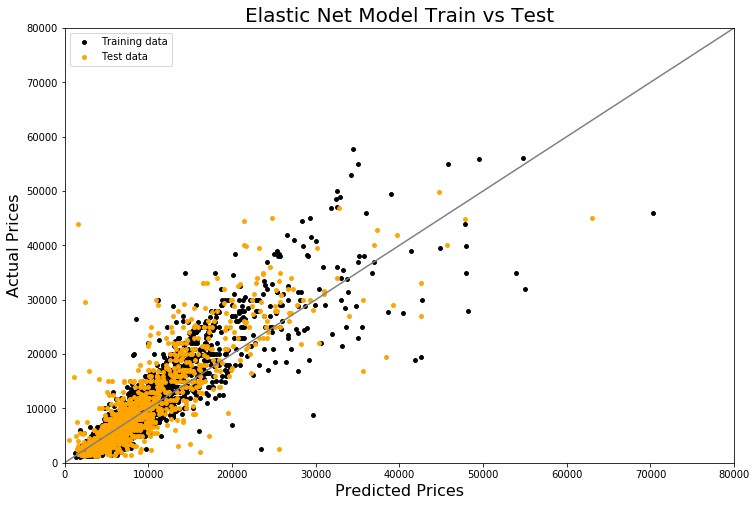

In [37]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_eNet,"Elastic Net")

###### Results

In [38]:
info = [['Elastic Net',mean_squared_error(y_test,eNet_pred),(eNet.score(X_test_scaled,y_test))],
        ['Elastic Net Grid Search',mean_squared_error(y_test,grid_eNet_pred),grid_eNet.score(X_test_scaled, y_test)]]
eNet_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
eNet_info

Name       MSE  R2-Score
0              Elastic Net  0.577823 -0.000418
1  Elastic Net Grid Search  0.198696  0.655986

##### XG Boost Model

In [69]:
#initialize xgboost
xgb = XGBRegressor()
xgb.set_params(random_state=22,objective='reg:squarederror')
xgb.fit(X_train_scaled, y_train)
print("Train R^2 is: %.5f" % xgb.score(X_train_scaled, y_train))
print("Test set R^2 is is: %.5f" % xgb.score(X_test_scaled, y_test))

Train R^2 is: 0.83068
Test set R^2 is is: 0.74102


In [70]:
r =xgb.score(X_test_scaled, y_test)

In [40]:
xgb_pred = xgb.predict(X_test_scaled)
printErrors(y_test, xgb_pred)

Mean Absolute Error (MAE): $ 2781.93
Mean Squared Error (MSE): 0.14958359120691989
Root Mean Square Error (RMSE): 0.38676037957231335
Root Mean Square Log Error (RMSLE): 0.039656677564257274
Mean Absolute Percent Error (MAPE): 32.23 %.


##### XG Boost Grid Search 1

In [41]:
xgb_param_grid ={'learning_rate': [0.05],
                 'max_depth': [3],
                 'min_child_weight': [4],
                 'n_estimators': [500]}

grid_search_xgb = ms.GridSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)

In [42]:
%time grid_search_xgb.fit(X_train_scaled, y_train)

Wall time: 2min 8s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=22, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [3],

In [43]:
grid_search_xgb.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 500}

In [44]:
grid_xgb = grid_search_xgb.best_estimator_

In [45]:
print("The train set R^2 is: %.5f" % grid_xgb.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_xgb.score(X_test_scaled, y_test))

The train set R^2 is: 0.85257
The test set R^2 is is: 0.75909


In [46]:
grid_xgb_pred = grid_xgb.predict(X_test_scaled)
printErrors(y_test, grid_xgb_pred)

Mean Absolute Error (MAE): $ 2598.35
Mean Squared Error (MSE): 0.13914278993949863
Root Mean Square Error (RMSE): 0.37301848471556825
Root Mean Square Log Error (RMSLE): 0.03823185425808781
Mean Absolute Percent Error (MAPE): 30.27 %.


##### XG Boost Grid Search 2

In [47]:
xgb_param_grid1 ={'learning_rate': [0.05],
                 'max_depth': [3],
                 'min_child_weight': [4],
                 'n_estimators': [500],
                 'subsample': [0.7],
                 'colsample_bytree' : [0.7],
                 'objective':['reg:squarederror'],
                 'nthread':[-1],
                 'scale_pos_weight':[1],
                 'seed':[27],
                 'reg_alpha': [0.00006]}
                 

grid_search_xgb1 = ms.GridSearchCV(xgb, xgb_param_grid1, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)
%time grid_search_xgb1.fit(X_train_scaled, y_train)

Wall time: 1min 37s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective...
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [3], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [-1],
                         'objective': ['reg:squarederror'],
                         'reg_alpha':

In [48]:
grid_search_xgb1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:squarederror',
 'reg_alpha': 6e-05,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 0.7}

In [49]:
grid_xgb1 = grid_search_xgb1.best_estimator_
print("The train set R^2 is: %.5f" % grid_xgb1.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_xgb1.score(X_test_scaled, y_test))

The train set R^2 is: 0.86422
The test set R^2 is is: 0.76050


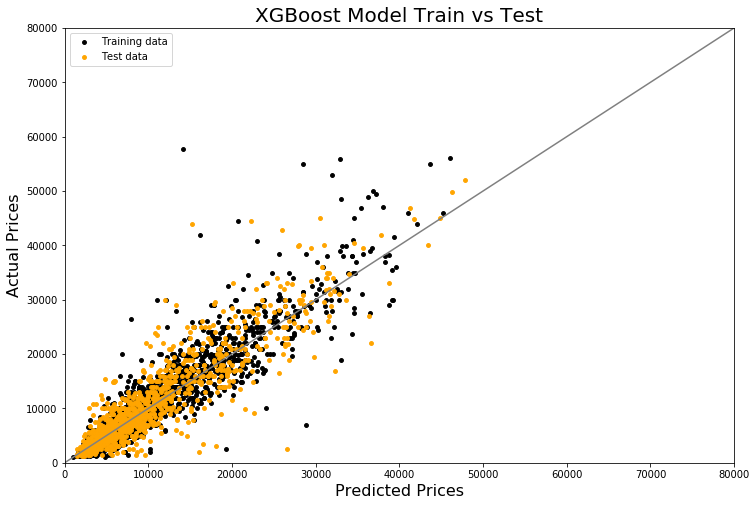

In [50]:
printMod(X_train_scaled,X_test_scaled, y_train,y_test,grid_xgb1,"XGBoost")

In [51]:
grid_xgb_pred1 = grid_xgb1.predict(X_test_scaled)

printErrors(y_test, grid_xgb_pred1)

Mean Absolute Error (MAE): $ 2582.51
Mean Squared Error (MSE): 0.13833267761517976
Root Mean Square Error (RMSE): 0.3719310119029869
Root Mean Square Log Error (RMSLE): 0.038138712757540945
Mean Absolute Percent Error (MAPE): 30.04 %.


#### Important Features

In [141]:
# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train_scaled.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances[:10]]

Variable: year                 Importance: 0.10763999819755554
Variable: drive_fwd            Importance: 0.06061000004410744
Variable: type_sedan           Importance: 0.05508999899029732
Variable: cylinders_8 cylinders Importance: 0.05451999977231026
Variable: type_truck           Importance: 0.05299999937415123
Variable: odometer_log         Importance: 0.0528700016438961
Variable: fuel_gas             Importance: 0.049720000475645065
Variable: cylinders_4 cylinders Importance: 0.036010000854730606
Variable: size_full-size       Importance: 0.031950000673532486
Variable: condition_fair       Importance: 0.026270000264048576


[None, None, None, None, None, None, None, None, None, None]

In [53]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))
xgb_feature_importances_top20

[('year', 0.10764),
 ('drive_fwd', 0.06061),
 ('type_sedan', 0.05509),
 ('cylinders_8 cylinders', 0.05452),
 ('type_truck', 0.053),
 ('odometer_log', 0.05287),
 ('fuel_gas', 0.04972),
 ('cylinders_4 cylinders', 0.03601),
 ('size_full-size', 0.03195),
 ('condition_fair', 0.02627),
 ('condition_good', 0.02361),
 ('state_nv', 0.02082),
 ('model_benz c300', 0.01506),
 ('drive_rwd', 0.01233),
 ('manufacturer_toyota', 0.01114),
 ('state_oh', 0.0111),
 ('state_in', 0.01098),
 ('model_durango', 0.01093),
 ('state_nh', 0.01033),
 ('state_ny', 0.01033)]

Text(0.5, 1.0, 'Feature Importances')

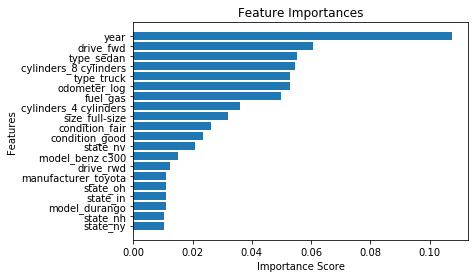

In [54]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

##### XG Boost Grid Search with important features

In [55]:
xgb_params_tuned_model = grid_search_xgb.best_estimator_
xgb_feature_importance = 100.0 * (xgb_params_tuned_model.feature_importances_ / xgb_params_tuned_model.feature_importances_.max())
xgb_important_features = X_train_scaled.columns[xgb_feature_importance >= 0.02]
xgb_unimportant_features = X_train_scaled.columns[xgb_feature_importance < 0.02]

In [56]:
xgb_important_features

Index(['year', 'odometer_log', 'manufacturer_audi', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_ford', 'manufacturer_gmc', 'manufacturer_honda',
       ...
       'state_nj', 'state_nv', 'state_ny', 'state_oh', 'state_ok', 'state_pa', 'state_tx', 'state_va', 'state_wa', 'state_wi'], dtype='object', length=115)

In [57]:
X_train_xgbreduced = X_train_scaled.drop(xgb_unimportant_features, axis=1)
X_test_xgbreduced = X_test_scaled.drop(xgb_unimportant_features, axis=1)

In [58]:
# GridSearchCV for multiple hyperparameters:
xgb=XGBRegressor()

xgb_param_grid ={'learning_rate': [0.05, 0.1, 0.15],
             'max_depth': [3, 4, 5],
             'n_estimators': [500]}

xgb.set_params(random_state=42)

grid_search_xgb2 = ms.GridSearchCV(xgb, xgb_param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = 7, return_train_score=True, verbose = 1)
grid_search_xgb2.fit(X_train_xgbreduced, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:   48.0s finished


[13:53:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=7,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
             

In [59]:
grid_search_xgb2.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [60]:
predictions_tuned_xgb2 = grid_search_xgb2.best_estimator_.predict(X_test_xgbreduced)

In [61]:
printErrors(y_test, predictions_tuned_xgb2)

Mean Absolute Error (MAE): $ 2599.81
Mean Squared Error (MSE): 0.14334936454631741
Root Mean Square Error (RMSE): 0.37861506117205296
Root Mean Square Log Error (RMSLE): 0.038866312557573404
Mean Absolute Percent Error (MAPE): 30.63 %.


###### Results

In [75]:
info = [['XGBoost',mean_squared_error(y_test,xgb_pred),xgb.score(X_test_scaled, y_test)],
        ['XGBoost Grid Search 1',mean_squared_error(y_test,grid_xgb_pred),grid_xgb.score(X_test_scaled, y_test)],
       ['XGBoost Grid Search 2', mean_squared_error(y_test, grid_xgb_pred1),grid_xgb1.score(X_test_scaled, y_test)],
       ['XG Boost Grid Search Impt.Feat', mean_squared_error(y_test,predictions_tuned_xgb2),grid_search_xgb2.score(X_test_xgbreduced,y_test)]]
xgb_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
xgb_info

Name       MSE  R2-Score
0                         XGBoost  0.149584  0.741017
1           XGBoost Grid Search 1  0.139143  0.759094
2           XGBoost Grid Search 2  0.138333  0.760497
3  XG Boost Grid Search Impt.Feat  0.143349 -0.143349

##### Random Forest

In [76]:
#initialize RF model
#default n estimators = 10 will be deprecated and changed to 100 by default in new version .22, 
#set parameter n_estimators to 10
rforest = RandomForestRegressor()

rforest.set_params(random_state=52,n_estimators=10,)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=52, verbose=0, warm_start=False)

In [77]:
#fit model on train data set
rforest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=52, verbose=0, warm_start=False)

In [78]:
#find R2 of model on train and test data sets
print("The train set R^2 is: %.5f" % rforest.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test_scaled, y_test))

The train set R^2 is: 0.95051
The test set R^2 is is: 0.69613


In [79]:
rforest_pred = rforest.predict(X_test_scaled)

In [80]:
printErrors(y_test, rforest_pred)

Mean Absolute Error (MAE): $ 2847.59
Mean Squared Error (MSE): 0.17551111981914228
Root Mean Square Error (RMSE): 0.4189404728826546
Root Mean Square Log Error (RMSLE): 0.04304003866674159
Mean Absolute Percent Error (MAPE): 35.55 %.


##### Random Forest Grid Search 1

In [81]:
# set parameter grid for kfold cross validation kfold is set above to 5
param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500]}

In [82]:
#test how different scoring impacts outcome...
grid_search_rforest = ms.GridSearchCV(rforest, param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)

In [83]:
%time grid_search_rforest.fit(X_train_scaled, y_train)

Wall time: 12min 55s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_es..._jobs=None,
                                             oob_score=False, random_state=52,
                                             verbose=0, warm_sta

In [84]:
# get the best parameters
grid_search_rforest.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [85]:
# Prediction using the tuned parameters
grid_rforest = grid_search_rforest.best_estimator_

In [86]:
print("The train set R^2 is: %.5f" % grid_rforest.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_rforest.score(X_test_scaled, y_test))

The train set R^2 is: 0.96472
The test set R^2 is is: 0.72570


In [87]:
#Prediction with tuned hyperparameters
grid_rforest_pred = grid_rforest.predict(X_test_scaled)

In [88]:

printErrors(y_test, grid_rforest_pred)

Mean Absolute Error (MAE): $ 2753.26
Mean Squared Error (MSE): 0.15842965271383122
Root Mean Square Error (RMSE): 0.3980322257227814
Root Mean Square Log Error (RMSLE): 0.04089342605148253
Mean Absolute Percent Error (MAPE): 33.48 %.


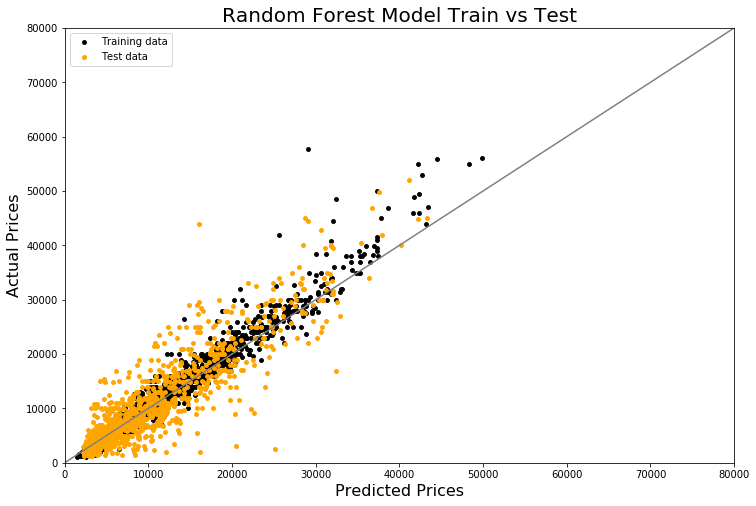

In [89]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_rforest,"Random Forest")

#### Random Forest Feature Importance

In [90]:
# Get numerical feature importances
feats_rf = list(rforest.feature_importances_)

# List of tuples with variable and importance
feats_rf_score = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, feats_rf)]

# Sort the feature importances by most important first
sorted_feats_rf_score = sorted(feats_rf_score, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in sorted_feats_rf_score]

Variable: year                 Importance: 0.42436
Variable: odometer_log         Importance: 0.13374
Variable: drive_fwd            Importance: 0.12693
Variable: fuel_gas             Importance: 0.04298
Variable: cylinders_8 cylinders Importance: 0.02892
Variable: cylinders_4 cylinders Importance: 0.01797
Variable: condition_fair       Importance: 0.00883
Variable: condition_good       Importance: 0.00848
Variable: type_truck           Importance: 0.00802
Variable: type_sedan           Importance: 0.0072
Variable: cylinders_6 cylinders Importance: 0.00694
Variable: model_durango        Importance: 0.00473
Variable: paint_color_white    Importance: 0.00441
Variable: model_535i           Importance: 0.00419
Variable: state_in             Importance: 0.00368
Variable: size_mid-size        Importance: 0.00366
Variable: transmission_manual  Importance: 0.00341
Variable: drive_rwd            Importance: 0.00315
Variable: state_nh             Importance: 0.00306
Variable: manufacturer_ram   

Variable: model_fj40 landcruiser Importance: 0.0
Variable: model_flex           Importance: 0.0
Variable: model_flex sel       Importance: 0.0
Variable: model_focus s        Importance: 0.0
Variable: model_focus st turbo Importance: 0.0
Variable: model_focus svt      Importance: 0.0
Variable: model_focus titanium Importance: 0.0
Variable: model_focus ztw,     Importance: 0.0
Variable: model_focus zx3      Importance: 0.0
Variable: model_focus zx4      Importance: 0.0
Variable: model_forester       Importance: 0.0
Variable: model_forester 2.0xt touring Importance: 0.0
Variable: model_forester 2.5i premium Importance: 0.0
Variable: model_forester 2.5l limited Importance: 0.0
Variable: model_forester 2.5x awd Importance: 0.0
Variable: model_forester 2.5x premium Importance: 0.0
Variable: model_forester awd   Importance: 0.0
Variable: model_forester sports x Importance: 0.0
Variable: model_forester x     Importance: 0.0
Variable: model_forestor       Importance: 0.0
Variable: model_forte  

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 1.0, 'Feature Importances')

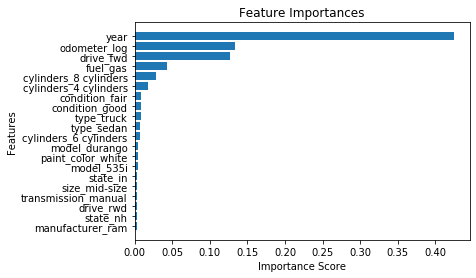

In [91]:
rf_feature_importances_top20 = sorted_feats_rf_score[:20]
featureNames, featureScores = zip(*list(rf_feature_importances_top20))

plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [92]:
rf_feature_importances_top20

[('year', 0.42436),
 ('odometer_log', 0.13374),
 ('drive_fwd', 0.12693),
 ('fuel_gas', 0.04298),
 ('cylinders_8 cylinders', 0.02892),
 ('cylinders_4 cylinders', 0.01797),
 ('condition_fair', 0.00883),
 ('condition_good', 0.00848),
 ('type_truck', 0.00802),
 ('type_sedan', 0.0072),
 ('cylinders_6 cylinders', 0.00694),
 ('model_durango', 0.00473),
 ('paint_color_white', 0.00441),
 ('model_535i', 0.00419),
 ('state_in', 0.00368),
 ('size_mid-size', 0.00366),
 ('transmission_manual', 0.00341),
 ('drive_rwd', 0.00315),
 ('state_nh', 0.00306),
 ('manufacturer_ram', 0.00296)]

In [93]:
grid_rforest = grid_search_rforest.best_estimator_
feature_importance = 100.0 * (grid_rforest.feature_importances_ / grid_rforest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 0.05]
unimportant_features = X_train.columns[feature_importance < 0.05]

In [94]:
X_train_reduced = X_train.drop(unimportant_features, axis=1)
X_test_reduced = X_test.drop(unimportant_features, axis=1)

#### Random Forest grid search with important features

In [95]:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = ms.GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 11.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_es...ors=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0

In [96]:
# get the best parameters
grid_search_rForest2.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 800}

In [97]:
predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(X_test_reduced)

# Calculate the absolute errors
errors = abs(np.expm1(predictions_tuned_rForest2) - np.expm1(y_test))

# Print out the mean absolute error (MAE)
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('MSE:', mean_squared_error(y_test, predictions_tuned_rForest2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_tuned_rForest2)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test))

# Calculate and display MAPE
#accuracy = 100 - np.mean(mape)
print('MAPE:', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 2720.26
MSE: 0.1576031443969546
RMSE: 0.3969926251165815
MAPE: 33.98 %.


##### Results

In [121]:
info = [['Random Forest',mean_squared_error(y_test,rforest_pred),(rforest.score(X_test_scaled,y_test))],
        ['Random Forest Grid Search 1',mean_squared_error(y_test,grid_rforest_pred),grid_rforest.score(X_test_scaled, y_test)],
       ['Random Forest Grid Search Impt.Feat',mean_squared_error(y_test, predictions_tuned_rForest2),grid_search_rForest2.score(X_test_reduced, y_test)]]
rf_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
rf_info

Name       MSE  R2-Score
0                        Random Forest  0.175511  0.696128
1          Random Forest Grid Search 1  0.158430  0.725702
2  Random Forest Grid Search Impt.Feat  0.157603 -0.157603

##### Stacking Model with all used models (Lasso, Elastic, XG Boost, Random Forest)

In [100]:
stackMod = StackingCVRegressor(regressors=(grid_lasso,grid_eNet,grid_xgb1,grid_rforest),
                              meta_regressor = grid_xgb, shuffle = True,
                              random_state = 20,
                              use_features_in_secondary= True)
%time stackMod.fit(X_train_scaled,y_train)

Wall time: 6min 57s


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=4,
                                                missing=None, n_estimators=500,
                                                n_jobs=1, nthread=None,
                                                objective='reg:squarederror',
                                                random_state=22, reg_alpha=0,...
                                

In [101]:
print("Train R^2: %.5f" % stackMod.score(np.array(X_train_scaled), np.array(y_train)))
print("Test R^2: %.5f" % stackMod.score(np.array(X_test_scaled), np.array(y_test)))

Train R^2: 0.88179
Test R^2: 0.75894


In [102]:
# Initial prediction
stackMod_pred = stackMod.predict(np.array(X_test_scaled))
printErrors(y_test, stackMod_pred)

Mean Absolute Error (MAE): $ 2605.39
Mean Squared Error (MSE): 0.13922925673725778
Root Mean Square Error (RMSE): 0.3731343682070278
Root Mean Square Log Error (RMSLE): 0.038326027553563374
Mean Absolute Percent Error (MAPE): 30.29 %.


In [115]:
info = [['Stacking',mean_squared_error(y_test,stackMod_pred),stackMod.score(np.array(X_test_scaled),np.array(y_test))]]
stack_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
stack_info

Name       MSE  R2-Score
0  Stacking  0.139229  0.758944

##### Stacking model without Elastic Net (highest MSE)

In [116]:
stackModModwoElas = StackingCVRegressor(regressors=(grid_lasso,grid_xgb1,grid_rforest),
                              meta_regressor = grid_xgb, shuffle = True,
                              random_state = 20,
                              use_features_in_secondary= True)
%time stackModModwoElas.fit(np.array(X_train_scaled),np.array(y_train))

Wall time: 6min 27s


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=4,
                                                missing=None, n_estimators=500,
                                                n_jobs=1, nthread=None,
                                                objective='reg:squarederror',
                                                random_state=22, reg_alpha=0,...
                                

In [117]:
print("Train R^2: %.5f" % stackModModwoElas.score(np.array(X_train_scaled), np.array(y_train)))
print("Test R^2: %.5f" % stackModModwoElas.score(np.array(X_test_scaled), np.array(y_test)))

Train R^2: 0.88446
Test R^2: 0.75872


In [118]:
# Initial prediction
stackModwoElas_pred = stackModModwoElas.predict(np.array(X_test_scaled))
printErrors(y_test, stackModwoElas_pred)

Mean Absolute Error (MAE): $ 2610.14
Mean Squared Error (MSE): 0.13935772877923683
Root Mean Square Error (RMSE): 0.3733064810303149
Root Mean Square Log Error (RMSLE): 0.03831566245695953
Mean Absolute Percent Error (MAPE): 30.3 %.


In [127]:
info = [['Stacking_no_eNet',mean_squared_error(y_test,stackModwoElas_pred),stackModModwoElas.score(np.array(X_test_scaled),np.array(y_test))]]
stack2_info = pd.DataFrame(info, columns= ['Name','MSE','R2-Score']) 
stack2_info

Name       MSE  R2-Score
0  Stacking_no_eNet  0.139358  0.758722

In [131]:
# Results
results = [lasso_info,eNet_info,xgb_info,rf_info,stack_info,stack2_info]
result = pd.concat(results,ignore_index=True)
models = result.sort_values(by = 'MSE')
models

Name       MSE  R2-Score
6                 XGBoost Grid Search 2  0.138333  0.760497
5                 XGBoost Grid Search 1  0.139143  0.759094
11                             Stacking  0.139229  0.758944
12                     Stacking_no_eNet  0.139358  0.758722
7        XG Boost Grid Search Impt.Feat  0.143349 -0.143349
4                               XGBoost  0.149584  0.741017
10  Random Forest Grid Search Impt.Feat  0.157603 -0.157603
9           Random Forest Grid Search 1  0.158430  0.725702
8                         Random Forest  0.175511  0.696128
3               Elastic Net Grid Search  0.198696  0.655986
1                     Lasso Grid Search  0.202751  0.648965
0                                 Lasso  0.577823 -0.000418
2                           Elastic Net  0.577823 -0.000418

### Final Model Selection
###### Overall, the XGBoost model is the preferred model, which performs better than the Random Forest and just as good as the Stacking model. It could possibly be improved further with hyper-parameter tuning. Thus, XGBoost was able to predict 76% of the variation of car sale prices.